## Setup


In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
%matplotlib inline

In [2]:
sns.set_style("whitegrid", {'axes.grid' : False})

## Data Preprocessing


In [3]:
data = pd.read_json("../data/processed/to_label.json")
data["tweetid"] = data.tweetid.astype(str)
data.head()

,tweetid,tweet_text,text,tech,label
0,295735762505322497,النعيم أمي، وعين أمي، وقبلة أمي، فأكرمها يالله...,النعيم أمي، وعين أمي، وقبلة أمي، فأكرمها يالله...,None,0
1,1080873494227886086,RT @rood516: عرض الاجازه😍👌🏻1\nســــاعه\nقـــلم...,RT : عرض الاجازه1 ســــاعه قـــلم كــبك نظـــا...,None,0
2,1027481525506453504,RT @6FSH1_: مهما ضاق صدرك تذكر أن في ناس توهم ...,RT : مهما ضاق صدرك تذكر أن في ناس توهم بيسجلون...,None,0
3,417202038037299200,RT @f450450: ﴿ياحي ياقيوم برحمتك أستغيث أصلح ل...,RT : ﴿ياحي ياقيوم برحمتك أستغيث أصلح لي شأني ك...,None,0
4,834074569673736193,RT @7744Qa: بعض البشر ، إذا وجد البديل نكر الج...,RT : بعض البشر ، إذا وجد البديل نكر الجميل. قر...,None,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2100 entries, 0 to 2099
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetid     2100 non-null   object
 1   tweet_text  2100 non-null   object
 2   text        2100 non-null   object
 3   tech        202 non-null    object
 4   label       2100 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 98.4+ KB


In [5]:
w = data.label.value_counts(normalize=True)
w

label
0    0.90381
1    0.09619
Name: proportion, dtype: float64

In [6]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(data, train_size=0.6, stratify=data.label, random_state=42)
valid, test = train_test_split(valid, train_size=0.5, stratify=valid.label, random_state=42)

In [7]:
lf_dev, _ = train_test_split(train, train_size=500, stratify=train.label, random_state=42)

In [8]:
len(train), len(valid), len(test), len(lf_dev)

(1260, 420, 420, 500)

In [9]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)


lf_dev = lf_dev.reset_index(drop=True)
lf_dev.to_json("../data/processed/lf_dev.json")
test.to_json("../data/processed/test_gold.json")

## Tokenization


In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('aubmindlab/bert-base-arabertv02-twitter')

In [11]:
# transformimg from pandas to hugging face datasets

from datasets import Dataset, DatasetDict

train = Dataset.from_pandas(train, split='train')
valid = Dataset.from_pandas(valid, split='validation')
test = Dataset.from_pandas(test, split='test')

ds = DatasetDict({'train': train, 'validation': valid, 'test': test})

ds

DatasetDict({
    train: Dataset({
        features: ['tweetid', 'tweet_text', 'text', 'tech', 'label'],
        num_rows: 1260
    })
    validation: Dataset({
        features: ['tweetid', 'tweet_text', 'text', 'tech', 'label'],
        num_rows: 420
    })
    test: Dataset({
        features: ['tweetid', 'tweet_text', 'text', 'tech', 'label'],
        num_rows: 420
    })
})

In [12]:
def tokenize_ds(field):
    '''Tokenize examples from dataset.'''
    return tokenizer(field['text'], truncation=True)

In [13]:
cols = ds["train"].column_names.copy()
cols

['tweetid', 'tweet_text', 'text', 'tech', 'label']

In [14]:
cols.remove("label")

In [15]:
ds_encoded = ds.map(tokenize_ds, batched=True, remove_columns=cols)

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

In [16]:
ds_encoded

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1260
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 420
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 420
    })
})

## Modeling


### Setup


In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [18]:
def compute_scores(preds):
    """Compute scores of transformers predictions."""
    logits, labels = preds
    pred = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred)
    prec = precision_score(labels, pred)
    rec = recall_score(labels, pred)
    return {"Accuracy": acc, 'Precision': prec, 'Recall': rec, "F1": f1}

In [19]:
id2label = {0: 'transparent', 1: 'propaganda'}
label2id = {'transparent': 0, 'propaganda': 1}

In [20]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [21]:
model = (AutoModelForSequenceClassification
         .from_pretrained("aubmindlab/bert-base-arabertv02-twitter", 
                          num_labels=2, id2label=id2label, 
                          label2id=label2id))

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmi

In [22]:
training_args = TrainingArguments(output_dir="../models/arabertv2-prop-supervised",
                                  overwrite_output_dir=True,
                                  learning_rate=5e-5, 
                                  per_device_train_batch_size=32, 
                                  per_device_eval_batch_size=32, 
                                  num_train_epochs=5,
                                  weight_decay=0.0001, 
                                  evaluation_strategy="epoch", 
                                  save_strategy="epoch", 
                                  load_best_model_at_end=True, 
                                  logging_steps=1,
                                  warmup_ratio=0.2)

### Training


In [23]:
import torch
from torch import nn
from transformers import Trainer

In [24]:
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    if torch.cuda.device_count() > 1:
        device = torch.device('cuda:0')
    else:
        device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [25]:
w_ = 1 / w.to_numpy()
w_ = w_ / w_.sum()
w_

array([0.09619048, 0.90380952])

In [26]:
w_ = torch.tensor(w_, device=device, dtype=torch.float32)

In [27]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels") # [batch_size, num_labels]
        # del inputs['labels']
        outputs = model(**inputs)
        logits = outputs.get("logits") # [batch_size, num_labels]
        loss_fct = nn.CrossEntropyLoss(weight=w_)
        loss = loss_fct(
            logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [28]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [29]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_encoded["train"],
    eval_dataset=ds_encoded["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_scores,
)

In [30]:
import json
import wandb

with open("../data/access_tokens.json") as f:
    login_key = json.load(f)["wandb"]["login"]

wandb.login(key=login_key)

wandb: Currently logged in as: e_hossam96. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\ehhho/.netrc


True

In [31]:
wandb.init(project="arabic-supervised-propaganda", name="arabert-wce")

In [32]:
trainer.train()

C:\Users\ehhho\anaconda3\envs\main\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.335900,0.429886,0.921429,0.586957,0.658537,0.620690
2,0.020500,0.726473,0.942857,0.869565,0.487805,0.625000
3,0.700600,0.798292,0.935714,0.694444,0.609756,0.649351
4,0.002200,0.947345,0.942857,0.742857,0.634146,0.684211
5,0.000600,1.020125,0.935714,0.718750,0.560976,0.630137


TrainOutput(global_step=200, training_loss=0.17849036550556774, metrics={'train_runtime': 358.1204, 'train_samples_per_second': 17.592, 'train_steps_per_second': 0.558, 'total_flos': 162925354366320.0, 'train_loss': 0.17849036550556774, 'epoch': 5.0})

In [33]:
trainer.evaluate(ds_encoded["test"], metric_key_prefix="test")

{'test_loss': 0.32565274834632874,
 'test_Accuracy': 0.9119047619047619,
 'test_Precision': 0.5254237288135594,
 'test_Recall': 0.775,
 'test_F1': 0.6262626262626263,
 'test_runtime': 2.6785,
 'test_samples_per_second': 156.807,
 'test_steps_per_second': 5.227,
 'epoch': 5.0}

In [34]:
test_outs = trainer.predict(ds_encoded['test'])
preds = np.argmax(test_outs[0], axis=-1)
labels = test_outs[1]

In [35]:
label_names = list(label2id.keys())

In [36]:
from sklearn.metrics import classification_report

print(classification_report(labels, preds, target_names=label_names))

              precision    recall  f1-score   support

 transparent       0.98      0.93      0.95       380
  propaganda       0.53      0.78      0.63        40

    accuracy                           0.91       420
   macro avg       0.75      0.85      0.79       420
weighted avg       0.93      0.91      0.92       420



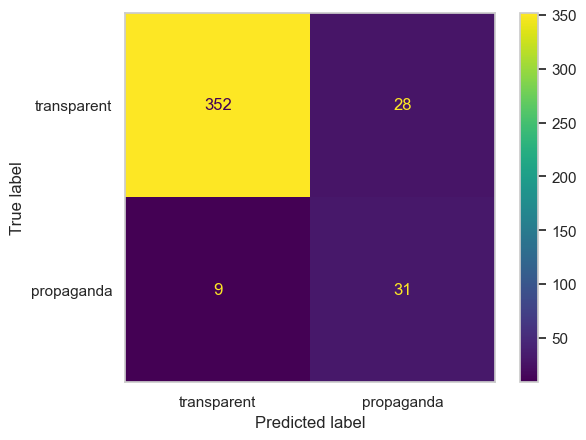

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)


disp.plot()
plt.show()

In [38]:
trainer.save_model("../models/arabertv2-prop-supervised")

In [39]:
wandb.finish()

eval/Accuracy,▁█▆█▆
eval/F1,▁▁▄█▂
eval/Precision,▁█▄▅▄
eval/Recall,█▁▆▇▄
eval/loss,▁▅▅▇█
eval/runtime,▁█▇▃▆
eval/samples_per_second,█▁▂▅▃
eval/steps_per_second,█▁▂▅▃
test/Accuracy,▁
test/F1,▁
test/Precision,▁
